In [1]:
# Import Libraries
import random
import math
from collections import deque
from ctypes import *
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7, 7]

from simon import SimonCipher

In [2]:
def fsamp(x, group):
    Mean = np.mean(group)

    Sigma = 0
    for i in group:
        Sigma += np.square(i-Mean)
    Sigma = np.sqrt(Sigma / (len(group) - 1))

    sg2s = 2 * np.square(Sigma)
    result = np.exp(-(np.square(x - Mean) / (sg2s)))/ np.sqrt(sg2s * math.pi)
    return result

In [3]:
def fpop(x, group):
    Mean = np.mean(group)

    Sigma = 0
    for i in group:
        Sigma += np.square(i-Mean)
    Sigma = np.sqrt(Sigma / len(group))

    sg2s = 2 * np.square(Sigma)
    result = np.exp(-(np.square(x - Mean) / (sg2s)))/ np.sqrt(sg2s * math.pi)
    return result

In [4]:
def sortab(a, b):
	for i in range(len(b)-1):
		for j in range(i+1, len(b)):
			if b[i] < b[j]:
				b[i], b[j] = b[j], b[i]
				a[i], a[j] = a[j], a[i]
	return a, b

In [5]:
def minimize(a, b, group):
	if fsamp(a, group)< fsamp(b, group):
		return a
	else:
		return b

In [6]:
def student(a, b, item, group):
	e = random.random()
	g = random.random()
	if fsamp(a, group) < fsamp(b, group):
		c = a + e*(a - b) + g*(a - item)
	else:
		c = a - e*(a - b) + g*(a - item)
	
	return c

In [7]:
# GTOA algorithm
def gtoa(max_iter, n, position):
    fx = fpop(position, position)

    ## Main loop of gtoa
    Iter = n
    while Iter < max_iter:
        # Step 1: Teacher allocation Phase
        position, fx  = sortab(position, fx)
        Xbest3 = np.array([position[i] for i in range(3)])
        # print("Xbest3:",Xbest3)

        if fx[0] <= fpop(np.mean(Xbest3), position):
            teacher = position[0]
        else: 
            teacher = np.mean(Xbest3) 

        # print("teacher:",teacher)

        # Step 2: Ability Grouping Phase
        og = np.array([position[i] for i in range(n//2)])
        ag =  np.array([position[i] for i in range(n//2, n)])
        # print("og, ag:\n",og, ag)
       

        # Step 3: Teacher phase(TP) and Student phase(SP)
        # TP1 for Outstanding group
        for i in range(len(og)):
            M = np.mean(og)
            b = random.random()
            a = random.random()
            Xteacher1 = og[i] + a*(teacher - 2*(b*M + (1-b)*og[i]))
            Xteacher1 = minimize(Xteacher1, og[i], og)


            # SP1 for Outstanding group
            rand_idx = random.randrange(len(og))
            random_num = og[rand_idx]
            Xstudent1 = student(Xteacher1, random_num, og[i], og)
            
            og[i] = minimize(Xteacher1, Xstudent1, og)
            


        # TP2 for Average group
        for i in range(len(ag)):
            d = random.random()            
            Xteacher2 = ag[i] + 2*d*(teacher - ag[i])
            Xteacher2 = minimize(Xteacher2, ag[i], ag)


            # SP2 for Average group
            rand_idx = random.randrange(len(ag))
            random_num = ag[rand_idx]
            Xstudent2 = student(Xteacher1, random_num, ag[i], ag)
            
            ag[i] = minimize(Xteacher2, Xstudent2, ag)
            
        
        position = np.concatenate((og, ag))
        fx = fpop(position, position)
        
        Iter += 2*n + 1
    # end-while
    
    index_of_Min_fx = np.where(fx == min(fx))[0][0]
    
    min_position = position[index_of_Min_fx]
    # print(position)
    # return best student from classroom
    return min_position

In [8]:
def Opt_key_gen_by_GTOA(key, key_size=128, block_size=128):
    """
    Initialize an instance of the Simon block cipher.
    :param key: Int representation of the encryption key
    :param key_size: Int representing the encryption key in bits
    :param block_size: Int representing the block size in bits
    :return: optimal key (opt_key)
    """

    # Z Arrays (stored bit reversed for easier usage)
    z0 = 0b01100111000011010100100010111110110011100001101010010001011111
    z1 = 0b01011010000110010011111011100010101101000011001001111101110001
    z2 = 0b11001101101001111110001000010100011001001011000000111011110101
    z3 = 0b11110000101100111001010001001000000111101001100011010111011011
    z4 = 0b11110111001001010011000011101000000100011011010110011110001011


    # valid cipher configurations stored:
    # block_size:{key_size:(number_rounds,z sequence)}
    valid_setups = {32: {64: (32, z0)},
                    48: {72: (36, z0), 96: (36, z1)},
                    64: {96: (42, z2), 128: (44, z3)},
                    96: {96: (52, z2), 144: (54, z3)},
                    128: {128: (68, z2), 192: (69, z3), 256: (72, z4)}}

    # Setup block/word size
    try:
        possible_setups =  valid_setups[block_size]
        block_size = block_size
        word_size =  block_size >> 1
    except KeyError:
        print('Invalid block size!')
        print('Please use one of the following block sizes:', [x for x in valid_setups.keys()])
        raise

    # Setup Number of Rounds, Z Sequence, and Key Size
    try:
        rounds,  zseq =  possible_setups[key_size]
        key_size = key_size
    except KeyError:
        print('Invalid key size for selected block size!!')
        print('Please use one of the following key sizes:', [x for x in  possible_setups.keys()])
        raise

    # Create Properly Sized bit mask for truncating addition and left shift outputs
    mod_mask = (2 **  word_size) - 1

    # Parse the given key and truncate it to the key length
    try:
        key = key & ((2 **  key_size) - 1)
    except (ValueError, TypeError):
        print('Invalid Key Value!')
        print('Please Provide Key as int')
        raise


    # Pre-compile key schedule
    m =  key_size //  word_size
    key_schedule = []

    # Create list of subwords from encryption key
    k_init = [(( key >> (word_size * ((m-1) - x))) &  mod_mask) for x in range(m)]
    for i in k_init:
        print(hex(i))

    k_reg = deque(k_init)  # Use queue to manage key subwords

    round_constant =  mod_mask ^ 3  # Round Constant is 0xFFFF..FC

    # Generate all round keys
    for x in range( rounds):
        rs_3 = ((k_reg[0] << ( word_size - 3)) + (k_reg[0] >> 3)) &  mod_mask

        if m == 4:
            rs_3 = rs_3 ^ k_reg[2]

        rs_1 = ((rs_3 << ( word_size - 1)) + (rs_3 >> 1)) &  mod_mask

        c_z = (( zseq >> (x % 62)) & 1) ^ round_constant

        new_k = c_z ^ rs_1 ^ rs_3 ^ k_reg[m - 1]

        key_schedule.append(k_reg.pop())
        k_reg.appendleft(new_k)

    max_iter = 500 #rounds * 7
    opt_key = gtoa(max_iter,  rounds,  key_schedule)

    return opt_key

In [9]:
def float_encrypt(x, w):
	bits = cast(pointer(c_float(x)), POINTER(c_int32)).contents.value
	e = w.encrypt(bits)
	return e

def float_decrypt(e, w):
	d = w.decrypt(e)
	y = cast(pointer(c_int32(d)), POINTER(c_float)).contents.value
	return round(y,2)

In [10]:
def encrypt_dataset(filename, my_simon):

	df = pd.read_csv(filename)
	cipher = [[0 for _ in range(len(df.iloc[0,:]))] for _ in range(len(df))]

	encrypt_times = [] # stroring encryption times
	per = 5 # measuring time for 5th segment of data
	start = time.time()

	for i in range(len(df)):
		for j in range(len(df.iloc[0,:])):
			cipher[i][j] = hex(float_encrypt(df.iloc[i,j], my_simon))
		
		if (i == len(df)//per -1):
			end = time.time()
			encrypt_times.append(round(end - start, 2))
			per-=1
	
	df1 = pd.DataFrame(cipher, columns=df.columns)
	df1.to_csv(f"Cipher_{filename}", index = False)  # header=df.columns
			
	return df1, encrypt_times

In [11]:
def decrypt_dataset(filename, my_simon):

	df = pd.read_csv(filename)
	decrypt_plain = [[0 for _ in range(len(df.iloc[0,:]))] for _ in range(len(df))]

	decrypt_times = [] # stroring decryption times
	per = 5 # measuring time for 5th segment of data
	start = time.time()

	for i in range(len(df)):
		for j in range(len(df.iloc[0,:])):
			decrypt_plain[i][j] = float_decrypt(int(df.iloc[i,j], 0), my_simon)
		
		if (i == len(df)//per -1):
			end = time.time()
			decrypt_times.append(round(end - start, 2))
			per-=1

	df1 = pd.DataFrame(decrypt_plain, columns=df.columns)
	df1.to_csv(f"Decrypt_{filename}", index = False)	#  header=df.columns
		
	return df1, decrypt_times

### **Optimal key generation**

In [12]:
key_size = 128
block_size = 64

hash = random.getrandbits(key_size)
print("hash:", hex(hash))

start = time.time()
opt_key = Opt_key_gen_by_GTOA(hash, key_size, block_size)
end = time.time()
opt_key_time = end - start

print("Opt_key Generation time: ", opt_key_time)
print("Opt_key: ", opt_key)

hash: 0x624ea13a03d068477bc445c406da3a2d
0x624ea13a
0x3d06847
0x7bc445c4
0x6da3a2d
Opt_key Generation time:  0.09635472297668457
Opt_key:  -8953100491


In [13]:
# If the opt_key in float
opt_key = cast(pointer(c_float(opt_key)), POINTER(c_int32)).contents.value
print("Optimal key: ", opt_key)

Optimal key:  -804951714


In [14]:
my_simon = SimonCipher(opt_key, key_size=128, block_size=64)

### For EEG Eye State dataset

In [15]:
plainfile1 = "EEG_Eye_State.csv"
cipherData1, encrypt_times1 = encrypt_dataset(plainfile1, my_simon)
decryptData1, decrypt_times1 = decrypt_dataset('Cipher_'+plainfile1, my_simon)

In [16]:
data_size = [20, 40, 60, 80, 100]
column = {  "Data Size":data_size,
			"Encryption Time (Sec.)": encrypt_times1, 
			"Decryption Time (Sec.)": decrypt_times1, 
		}	

times_df1 = pd.DataFrame(column)
times_df1

,Data Size,Encryption Time (Sec.),Decryption Time (Sec.)
0,20,3.03,3.05
1,40,3.83,3.82
2,60,5.10,5.06
3,80,7.71,7.62
4,100,15.61,15.21


In [17]:
pd.read_csv(plainfile1).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,1
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,1
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,1
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,1
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,1


In [18]:
decryptData1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,1.0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,1.0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,1.0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,1.0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,1.0


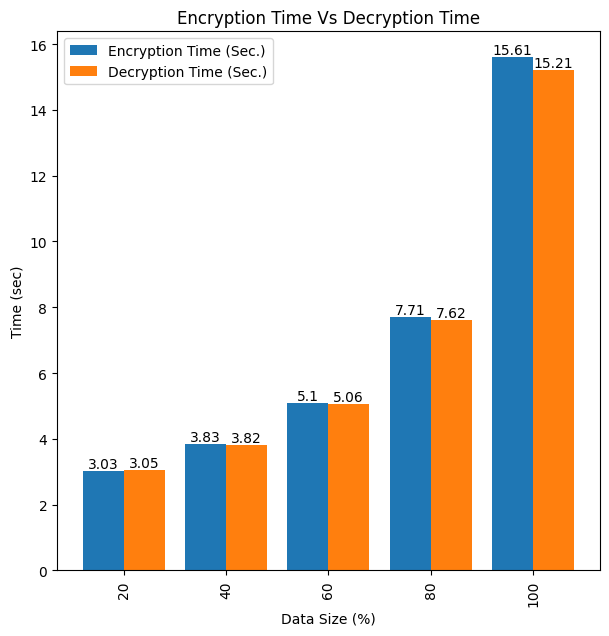

In [19]:
ax = times_df1.plot(kind ='bar', x ='Data Size', width=0.8)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Data Size (%)')
plt.ylabel('Time (sec)')
plt.title("Encryption Time Vs Decryption Time")
plt.show()

### For Patient Treatement Classification dataset

In [20]:
plainfile2 = "PTC.csv"
cipherData2, encrypt_times2 = encrypt_dataset(plainfile2, my_simon)
decryptData2, decrypt_times2 = decrypt_dataset('Cipher_'+plainfile2, my_simon)

In [21]:
data_size = [20, 40, 60, 80, 100]
column = {  "Data Size":data_size,
			"Encryption Time (Sec.)": encrypt_times2, 
			"Decryption Time (Sec.)": decrypt_times2, 
		}	
times_df2 = pd.DataFrame(column)
times_df2

,Data Size,Encryption Time (Sec.),Decryption Time (Sec.)
0,20,0.66,0.72
1,40,0.83,0.93
2,60,1.14,1.21
3,80,2.29,1.76
4,100,4.35,3.62


In [22]:
pd.read_csv(plainfile2).head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,0,0
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,0,0
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,0,0
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,0,0
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,1,0


In [23]:
decryptData2.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310.0,25.4,33.6,75.5,1.0,0.0,0.0
1,43.5,14.8,5.39,12.7,334.0,27.5,34.0,80.7,1.0,0.0,0.0
2,33.5,11.3,4.74,13.2,305.0,23.8,33.7,70.7,1.0,0.0,0.0
3,39.1,13.7,4.98,10.5,366.0,27.5,35.0,78.5,1.0,0.0,0.0
4,30.9,9.9,4.23,22.1,333.0,23.4,32.0,73.0,1.0,1.0,0.0


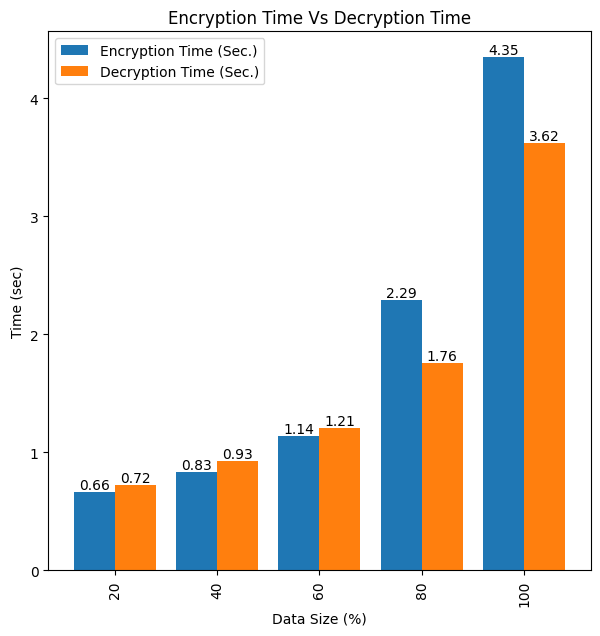

In [24]:
ax = times_df2.plot(kind ='bar', x ='Data Size', width =0.8)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Data Size (%)')
plt.ylabel('Time (sec)')
plt.title("Encryption Time Vs Decryption Time")
plt.show()